<a href="https://colab.research.google.com/github/soyudea/StrokePredictionModel/blob/main/04_modelo_con_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
from seaborn import distplot
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score, mean_squared_error
from matplotlib.patches import split_path_inout
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

from sklearn.model_selection import GridSearchCV

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler

from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_auc_score

**1. Cargar Dataset**

Se carga el dataset final luego del preprocesamiento. Se cargan los archivos Dataset.csv y y.csv

In [ ]:
X = pd.read_csv('Dataset.csv', sep=",") 
y = pd.read_csv('y.csv', sep=",") 

X=X.drop(columns=['Unnamed: 0'])
y=y.drop(columns=['Unnamed: 0'])


**2. Generador de muestras sintéticas**

In [ ]:
pca=PCA(n_components=30) 
pca.fit(X) #
X_pca=pca.transform(X)

In [ ]:
ros = RandomOverSampler(random_state=42, sampling_strategy=1.0)                          
Xres, yres = ros.fit_resample(X_pca, y)
Xtrain, Xtst, ytrain, ytst = train_test_split(Xres,yres, test_size=0.1) #Se toma el 90 % de los datos para Entrenar
print (Xtrain.shape, ytrain.shape, Xtst.shape, ytst.shape)
X=Xtrain
y=ytrain

(26409, 30) (26409, 1) (2935, 30) (2935, 1)


**3. Cálculo pesos de la clase Parámetro que se usa para minimizar el efecto del desbalance del dataset**

In [ ]:
def dar_peso_clase():
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, train_size = 0.8, random_state = 17)
  Number_Muestras_por_Clase = ytrain.value_counts()
  Number_Muestras_por_Clase = Number_Muestras_por_Clase.sort_index(axis = 0, ascending = True)
  Numero_de_Clases = len(Number_Muestras_por_Clase.index)
  Peso_por_Clase = len(ytrain)/(Numero_de_Clases*Number_Muestras_por_Clase)
  return Peso_por_Clase

**4. Modelo de clasificación random Forest Entrenamiento con el 90 % de los datos**

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [15]:
weight = dar_peso_clase() 
kf = KFokf = KFold(n_splits=10, random_state = True,shuffle=True)

X_test =0
Y_test =0

#warm_start mejoro la velocidad de ejecucion, mejoró la metrica
classifier = RandomForestClassifier(min_samples_split=10,
                                    ccp_alpha=0.000001,
                                    criterion='gini',
                                    class_weight = {0: weight[0], 1: weight[1]},
                                    random_state=True,max_features ="sqrt",
                                    warm_start=True,min_impurity_decrease=0.000005)

for train_index, test_index in kf.split(X):
    
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]
    modelo = classifier.fit(Xtrain, ytrain)
    ypred = modelo.predict(Xtest)

    print()
    print(confusion_matrix(ytest, ypred))
    print(classification_report(ytest, ypred, digits =4, labels=[0,1]))
    s = roc_auc_score(ytest, modelo.predict(Xtest))
    print(f'Best val auc: {s: .4f}')

<ipython-input-15-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)



[[ 976  322]
 [ 186 1157]]
              precision    recall  f1-score   support

           0     0.8399    0.7519    0.7935      1298
           1     0.7823    0.8615    0.8200      1343

    accuracy                         0.8076      2641
   macro avg     0.8111    0.8067    0.8067      2641
weighted avg     0.8106    0.8076    0.8070      2641

Best val auc:  0.8067

[[ 983  310]
 [ 160 1188]]
              precision    recall  f1-score   support

           0     0.8600    0.7602    0.8071      1293
           1     0.7931    0.8813    0.8349      1348

    accuracy                         0.8220      2641
   macro avg     0.8265    0.8208    0.8210      2641
weighted avg     0.8258    0.8220    0.8212      2641



<ipython-input-15-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-15-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Best val auc:  0.8208

[[1017  333]
 [ 148 1143]]
              precision    recall  f1-score   support

           0     0.8730    0.7533    0.8087      1350
           1     0.7744    0.8854    0.8262      1291

    accuracy                         0.8179      2641
   macro avg     0.8237    0.8193    0.8175      2641
weighted avg     0.8248    0.8179    0.8173      2641

Best val auc:  0.8193


<ipython-input-15-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-15-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(



[[ 977  349]
 [ 172 1143]]
              precision    recall  f1-score   support

           0     0.8503    0.7368    0.7895      1326
           1     0.7661    0.8692    0.8144      1315

    accuracy                         0.8027      2641
   macro avg     0.8082    0.8030    0.8019      2641
weighted avg     0.8084    0.8027    0.8019      2641

Best val auc:  0.8030

[[ 991  341]
 [ 167 1142]]
              precision    recall  f1-score   support

           0     0.8558    0.7440    0.7960      1332
           1     0.7701    0.8724    0.8181      1309

    accuracy                         0.8076      2641
   macro avg     0.8129    0.8082    0.8070      2641
weighted avg     0.8133    0.8076    0.8069      2641

Best val auc:  0.8082

[[ 974  316]
 [ 169 1182]]
              precision    recall  f1-score   support

           0     0.8521    0.7550    0.8007      1290
           1     0.7891    0.8749    0.8298      1351

    accuracy                         0.8164      2641


<ipython-input-15-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(
<ipython-input-15-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(



[[ 953  343]
 [ 156 1189]]
              precision    recall  f1-score   support

           0     0.8593    0.7353    0.7925      1296
           1     0.7761    0.8840    0.8266      1345

    accuracy                         0.8111      2641
   macro avg     0.8177    0.8097    0.8095      2641
weighted avg     0.8169    0.8111    0.8099      2641

Best val auc:  0.8097

[[1026  320]
 [ 158 1137]]


<ipython-input-15-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


              precision    recall  f1-score   support

           0     0.8666    0.7623    0.8111      1346
           1     0.7804    0.8780    0.8263      1295

    accuracy                         0.8190      2641
   macro avg     0.8235    0.8201    0.8187      2641
weighted avg     0.8243    0.8190    0.8185      2641

Best val auc:  0.8201

[[ 960  362]
 [ 141 1178]]


<ipython-input-15-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


              precision    recall  f1-score   support

           0     0.8719    0.7262    0.7924      1322
           1     0.7649    0.8931    0.8241      1319

    accuracy                         0.8095      2641
   macro avg     0.8184    0.8096    0.8082      2641
weighted avg     0.8185    0.8095    0.8082      2641

Best val auc:  0.8096

[[ 992  346]
 [ 149 1153]]
              precision    recall  f1-score   support

           0     0.8694    0.7414    0.8003      1338
           1     0.7692    0.8856    0.8233      1302

    accuracy                         0.8125      2640
   macro avg     0.8193    0.8135    0.8118      2640
weighted avg     0.8200    0.8125    0.8116      2640

Best val auc:  0.8135


<ipython-input-15-4968c50d344a>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  modelo = classifier.fit(Xtrain, ytrain)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


**5. Curva ROC: RandomForest**


Sin entrenar: ROC AUC=0.500
Algoritmo RandomForest: ROC AUC=0.813




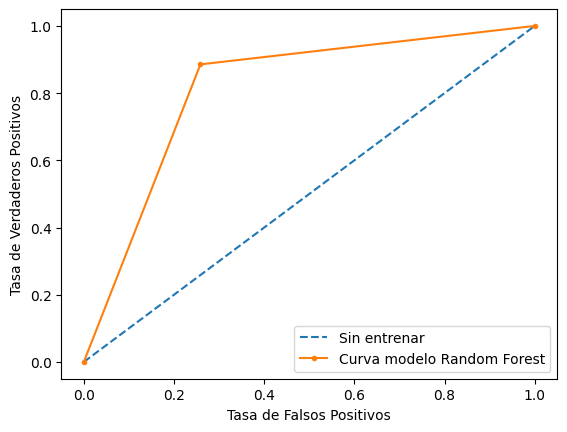

In [16]:
classes = classifier.predict(Xtest)
ns_probs = [0 for _ in range(len(ytest))]
ns_auc = roc_auc_score(ytest, ns_probs,average='weighted')
classifier_auc = roc_auc_score(ytest,classes,average='weighted')
#aps = average_precision_score(ytest, ns_probs)
print()
#print("Average_presicion_score "+str(aps))
print('Sin entrenar: ROC AUC=%.3f' % (ns_auc))
print('Algoritmo RandomForest: ROC AUC=%.3f' % (classifier_auc))
print()
classifier_probs = classes[:]
ns_fpr, ns_tpr, _ = roc_curve(ytest, ns_probs)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Sin entrenar')
classifier_fpr,classifier_tpr, _ = roc_curve(ytest, classifier_probs)
print()
pyplot.plot(classifier_fpr,classifier_tpr, marker='.', label='Curva modelo Random Forest')
pyplot.xlabel('Tasa de Falsos Positivos')
pyplot.ylabel('Tasa de Verdaderos Positivos')
pyplot.legend()
pyplot.show()